# **Import Libraries**

In [6]:
# ignore warning sentence
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

## wrapper method to select feature
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EXS
from sklearn.pipeline import Pipeline

## Evaluation tool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from colorama import Fore

In [7]:
def load_data(path):   # load data
    df = pd.read_csv(path)
    data_np = df.values
    return data_np

def feature_selection(f, df):
    '''
    input:
    f：(12: all features), (3: 3 features), (5: 5 features)
    df：original data
    
    output:
    df_fs：get new df after feature selection
    '''
    label = df[:, 12]
    if f == 12:   ## (1) all features
        df_fs = df[:, :12]
    elif f == 5:   ## (2) 5 features (time, ejection_fraction, serum_creatinine, age, serum_sodium)
        df_fs = np.concatenate((df[:, 0][:, np.newaxis], df[:, 4][:, np.newaxis],
                     df[:, 7][:, np.newaxis], df[:, 8][:, np.newaxis], df[:, 11][:, np.newaxis]), axis=1)
    elif f == 3:   ## (3) 3 features (time, ejection_fraction, serum_creatinine)
        df_fs =  np.concatenate((df[:, 4][:, np.newaxis], df[:, 7][:, np.newaxis], df[:, 11][:, np.newaxis]), axis=1)
    else:
        print(Fore.RED + "Please input '12: for all features',  '3: for 3 features', '5: for 5 features'")
    return df_fs, label

# Standardize Data 對數據做標準化
# 使數據在相同區間, 是將資料常態分布化，平均值會變為0, 標準差變為1，使離群值影響降低
def standardize(df_fs):
    standard_scaler = StandardScaler()
    df_scaled = standard_scaler.fit_transform(df_fs)
    return df_scaled


def pca_function(df, label, COMPONENTS):
    pca = PCA()
    pca.fit(df)
    x_pca = pca.transform(df)
    
    print(pca.explained_variance_ratio_) 
    
    tot = sum(pca.explained_variance_ratio_)
    var_exp = [(i / tot) for i in pca.explained_variance_ratio_]
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize=(10,8))
    plt.bar(x=range(1,13), height=var_exp, label='individual explained variance')
    plt.step(range(1, 13), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()
    
    
    if COMPONENTS == 2:
        plt.figure(figsize=(8,6))
        plt.scatter(x_pca[:,0],x_pca[:,1],c=label,cmap='plasma')
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.show()
    elif COMPONENTS ==3:
        ex_variance = np.var(x_pca, axis=0)
        ex_variance_ratio = ex_variance/np.sum(ex_variance)
        #ex_variance_ratio
        
        Xax = x_pca[:,0]
        Yax = x_pca[:,1]
        Zax = x_pca[:,2]

        cdict = {0:'red',1:'green'}
        labl = {0:'alive',1:'death'}
        marker = {0:'*',1:'o'}
        alpha = {0:.3, 1:.5}

        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111, projection='3d')

        fig.patch.set_facecolor('white')
        for l in np.unique(label):
            ix=np.where(label==l)
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])
        # for loop ends
        ax.set_xlabel("First Principal Component", fontsize=12)
        ax.set_ylabel("Second Principal Component", fontsize=12)
        ax.set_zlabel("Third Principal Component", fontsize=12)
        ax.legend()
        plt.show()
    return x_pca

def Evaluation(name, grid, x_test, y_test, pred): #, pred_score):
    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='weighted')
    precision = precision_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    
    print(Fore.GREEN + "Accuracy of {} Classifier is: ".format(name), "{:.2f}%".format(100*acc))
    print(Fore.GREEN + "Recall of {} Classifier is: ".format(name), "{:.2f}%".format(100*recall))
    print(Fore.GREEN + "Precision of {} Classifier is: ".format(name), "{:.2f}%".format(100*precision))
    print(Fore.GREEN + "f1-score of {} Classifier is: ".format(name), "{:.2f}%".format(100*f1))
    
    plot_confusion_matrix(grid, x_test, y_test)
    plt.show()

In [8]:
# logistic regression Classifier
def LR_Classifier(x_train, x_test, y_train, y_test):
    model = LogisticRegression()

    param_grid = {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear'], 'C': [
    0.01, 0.1, 10, 100], 'max_iter': [1000, 5000, 10000]}

    grid = GridSearchCV(model, param_grid, verbose=0)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)
    #pred_score = grid.predict_proba(x_test)
    
    print("Best parameter: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    Evaluation('Logistic Regression', grid, x_test, y_test, pred)

    
def LR_Classifier_WrapperMethod(x_train, x_test, y_train, y_test):
    '''
    # efs
    model = LogisticRegression()
    param_grid = {'efs__estimator__penalty': ['l2'], 'efs__estimator__solver': ['lbfgs'], 'efs__estimator__C': [0.01], 'efs__estimator__max_iter': [1000]}
    #param_grid = {'efs__estimator__penalty': ['l2'], 'efs__estimator__solver': ['lbfgs', 'liblinear'], 'efs__estimator__C': [
    #    0.01, 0.1, 10, 100], 'efs__estimator__max_iter': [1000, 5000, 10000]}
    efs = EXS(model, min_features=2, max_features=12,
              scoring='accuracy')

    pipe = Pipeline([('efs', efs), ('model', model)])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy')
    grid.fit(x_train, y_train)
    print(grid.best_estimator_)
    print(grid.best_estimator_.named_steps['efs'].k_feature_idx_)
    print(grid.best_estimator_.named_steps['efs'].estimator)
    #efs.fit(x_train, y_train)
    #print(f'Best score: {efs.best_score_}')
    # print(pd.DataFrame(efs.get_metric_dict()))

    #xx = np.zeros(
    #    (299, len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)))

    #for i in range(len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)):
    #    xx[:, i] = data_np[:, grid.best_estimator_.named_steps['efs'].k_feature_idx_[i]]

    #x_train_sel, x_test_sel, y_train, y_test = train_test_split(
    #    xx, y, random_state=1, test_size=0.2)

    x_efs_train = grid.transform(x_train)
    x_efs_test = grid.transform(x_test)
    model = grid.best_estimator_.named_steps['efs'].estimator
    model.fit(x_efs_train, y_train)
    pred = model.predict(x_efs_test)
    acc = accuracy_score(y_test, pred)
    print("Decision Tree Success Rate :", "{:.2f}%".format(100*acc))
    '''
    
    model = LogisticRegression(penalty='l2', solver='liblinear', C=0.01, max_iter=10000)
    rfecv = RFECV(estimator=model, step=1, cv=KFold(2), scoring='accuracy', verbose=0)
    rfecv.fit(x_train, y_train)

    x_rfecv_train = rfecv.transform(x_train)
    x_rfecv_test = rfecv.transform(x_test)

    model.fit(x_rfecv_train, y_train)
    pred = model.predict(x_rfecv_test)
    acc = accuracy_score(y_test, pred)
    Evaluation('Logistic Regression', model, x_rfecv_test, y_test, pred)
    print("Number of selected feature: %d" % rfecv.n_features_)
    #print("Feature Rank: %s" % list(rfecv.ranking_))
    print("Accuracy of Logistic Regression Classifier is: ", "{:.2f}%".format(100*acc))
    

In [9]:
# K Neighbors Classifier
def KNN_Classifier(x_train, x_test, y_train, y_test):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10, 50]}
    
    grid = GridSearchCV(model, param_grid, verbose=0)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)
    #pred_score = grid.predict_proba(x_test)
    print("Best parameter: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    Evaluation('KNN', grid, x_test, y_test, pred)

    
def KNN_Classifier_WrapperMethod(x_train, x_test, y_train, y_test):
    model = KNeighborsClassifier(n_neighbors=9)
    exs = EXS(model, min_features=2, max_features=12,
              scoring='accuracy')
    exs.fit(x_train, y_train)
    
    x_exs_train = exs.transform(x_train)
    x_exs_test = exs.transform(x_test)

    model.fit(x_exs_train, y_train)
    pred = model.predict(x_exs_test)
    acc = accuracy_score(y_test, pred)
    Evaluation('KNN', model, x_exs_test, y_test, pred)
    #print(exs.k_features_)
    print("Number of selected feature: %d" % len(exs.best_idx_))
    print("Accuracy of Decision Tree Classifier is: ", "{:.2f}%".format(100*acc))

In [10]:
# SVM
def SVM_Classifier(x_train, x_test, y_train, y_test):
    param_grid = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4], 'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]

    model = SVC(probability=True)
    grid = GridSearchCV(model, param_grid, verbose=0)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)
    #pred_score = grid.predict_proba(x_test)
    
    print("Best parameter: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    Evaluation('SVM', grid, x_test, y_test, pred)
    
def SVM_Classifier_WrapperMethod(x_train, x_test, y_train, y_test):
    '''
    # efs
    model = SVC()

    param_grid = [{'efs__estimator__kernel': ['rbf'], 'efs__estimator__gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4], 'efs__estimator__C': [0.1, 1, 10, 100, 1000]},
              {'efs__estimator__kernel': ['linear'], 'efs__estimator__C': [0.1, 1, 10, 100]}]

    efs = EXS(model, min_features=2, max_features=12,
              scoring='accuracy')

    pipe = Pipeline([('efs', efs), ('model', model)])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy')
    grid.fit(x_train, y_train)
    print(grid.best_estimator_)
    print(grid.best_estimator_.named_steps['efs'].k_feature_idx_)
    print(grid.best_estimator_.named_steps['efs'].estimator)
    #efs.fit(x_train, y_train)
    #print(f'Best score: {efs.best_score_}')
    # print(pd.DataFrame(efs.get_metric_dict()))

    #xx = np.zeros(
    #    (299, len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)))

    #for i in range(len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)):
    #    xx[:, i] = data_np[:, grid.best_estimator_.named_steps['efs'].k_feature_idx_[i]]

    #x_train_sel, x_test_sel, y_train, y_test = train_test_split(
    #    xx, y, random_state=1, test_size=0.2)

    x_efs_train = grid.transform(x_train)
    x_efs_test = grid.transform(x_test)
    model = grid.best_estimator_.named_steps['efs'].estimator
    model.fit(x_efs_train, y_train)
    pred = model.predict(x_efs_test)
    acc = accuracy_score(y_test, pred)
    print("Decision Tree Success Rate :", "{:.2f}%".format(100*acc))
    '''
    
    
    model = SVC(kernel="linear", C=1)
    #model = SVC(kernel="rbf", C=10, gamma=1e-3)
    rfecv = RFECV(estimator=model, step=1, cv=KFold(2), scoring='accuracy', min_features_to_select=12, verbose=0)
    rfecv.fit(x_train, y_train)

    x_rfecv_train = rfecv.transform(x_train)
    x_rfecv_test = rfecv.transform(x_test)

    model.fit(x_rfecv_train, y_train)
    pred = model.predict(x_rfecv_test)
    acc = accuracy_score(y_test, pred)

    print("Number of selected feature: %d" % rfecv.n_features_)
    #print("Feature Rank: %s" % list(rfecv.ranking_))
    Evaluation('SVM', model, x_rfecv_test, y_test, pred)
    
    

In [11]:
# Decision Tree Classifier
def DT_Classifier(x_train, x_test, y_train, y_test):
    model = DecisionTreeClassifier()
    param_grid = {'criterion': ['entropy'], 'max_depth': [
        i for i in range(4, 10)], 'random_state': [1]}
    grid = GridSearchCV(model, param_grid, verbose=0)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)
    #pred_score = grid.predict_proba(x_test)
    
    print("Best parameter: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    Evaluation('Decision Tree', grid, x_test, y_test, pred)

def DT_Classifier_WrapperMethod(x_train, x_test, y_train, y_test):
    '''
    # efs
    model = DecisionTreeClassifier()

    param_grid = {'efs__estimator__criterion': ['entropy'], 'efs__estimator__max_depth': [i for i in range(4, 10)], 'efs__estimator__random_state': [1]}

    efs = EXS(model, min_features=2, max_features=12,
              scoring='accuracy')

    pipe = Pipeline([('efs', efs), ('model', model)])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy')
    grid.fit(x_train, y_train)
    print(grid.best_estimator_)
    print(grid.best_estimator_.named_steps['efs'].k_features)
    print(grid.best_estimator_.named_steps['efs'].estimator)
    #efs.fit(x_train, y_train)
    #print(f'Best score: {efs.best_score_}')
    # print(pd.DataFrame(efs.get_metric_dict()))

    #xx = np.zeros(
    #    (299, len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)))

    #for i in range(len(grid.best_estimator_.named_steps['efs'].k_feature_idx_)):
    #    xx[:, i] = data_np[:, grid.best_estimator_.named_steps['efs'].k_feature_idx_[i]]

    #x_train_sel, x_test_sel, y_train, y_test = train_test_split(
    #    xx, y, random_state=1, test_size=0.2)

    x_efs_train = grid.transform(x_train)
    x_efs_test = grid.transform(x_test)
    model = grid.best_estimator_.named_steps['efs'].estimator
    model.fit(x_efs_train, y_train)
    pred = model.predict(x_efs_test)
    acc = accuracy_score(y_test, pred)
    print("Decision Tree Success Rate :", "{:.2f}%".format(100*acc))
    '''
    model = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)
    rfecv = RFECV(estimator=model, step=1, cv=KFold(2), scoring='accuracy', min_features_to_select=8, verbose=0)
    rfecv.fit(x_train, y_train)

    x_rfecv_train = rfecv.transform(x_train)
    x_rfecv_test = rfecv.transform(x_test)

    model.fit(x_rfecv_train, y_train)
    pred = model.predict(x_rfecv_test)
    acc = accuracy_score(y_test, pred)

    print("Number of selected feature: %d" % rfecv.n_features_)
    #print("Feature Rank: %s" % list(rfecv.ranking_))
    Evaluation('Decision Tree', model, x_rfecv_test, y_test, pred)

In [12]:
# MLP
# HIDDEN_LAYER_SIZES = (8, 16)#(13, 20, 30)
# ACTIVATION = 'relu' # (e.g. {'identity', 'logistic', 'tanh', 'relu'), default = 'relu'}
# SOLVER = 'adam' # e.g. {'lbfgs', 'sgd', 'adam'}, default=’adam’
# LEARNING_RATE = 0.001
# ITER = 500 #150

def MLP_Classifier(x_train, x_test, y_train, y_test):
    model = MLPClassifier()
    param_grid = {'hidden_layer_sizes':[(8, 16)], 'activation': ['identity', 'logistic', 'tanh', 'relu']
                  , 'solver':['lbfgs', 'sgd', 'adam']
                  , 'learning_rate': ['constant'], 'learning_rate_init': [0.001], 'tol': [0.0001], 'max_iter':[500]
                 , 'max_fun':[20000], 'random_state':[0]}
    
    grid = GridSearchCV(model, param_grid, verbose=0)
    grid.fit(x_train, y_train)
    pred = grid.predict(x_test)
    #pred_score = grid.predict_proba(x_test)
    
    print("Best parameter: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    Evaluation('MLP', grid, x_test, y_test, pred)

def MLP_Classifier_WrapperMethod(x_train, x_test, y_train, y_test):
    model = MLPClassifier(hidden_layer_sizes=(8, 16),
                           activation='identity',
                           solver='sgd',
                           learning_rate='constant',
                           learning_rate_init=0.001,
                           tol=0.0001,
                           max_iter=500,
                           verbose=False,
                           max_fun=20000,
                           random_state=0)
    
    sfs = SFS(model, k_features=(1, 12))
    sfs.fit(x_train, y_train)
    
    x_sfs_train = sfs.transform(x_train)
    x_sfs_test = sfs.transform(x_test)

    model.fit(x_sfs_train, y_train)
    pred = model.predict(x_sfs_test)
    acc = accuracy_score(y_test, pred)

    print("Number of selected feature: %d" % len(sfs.k_feature_idx_))
    Evaluation('MLP', model, x_sfs_test, y_test, pred)

# **Explore the datasets**

In [15]:
path = 'C:\\Users\\ASUS\\Desktop\\heart_failure_clinical_records_dataset.csv'
# path = './heart_failure_clinical_records_dataset.csv'
# path = 'C:\\Users\\ASUS\\Desktop\\heart_failure_clinical_records_dataset_2.csv'
data = load_data(path)
print(data.shape)

(299, 13)


<AxesSubplot:>

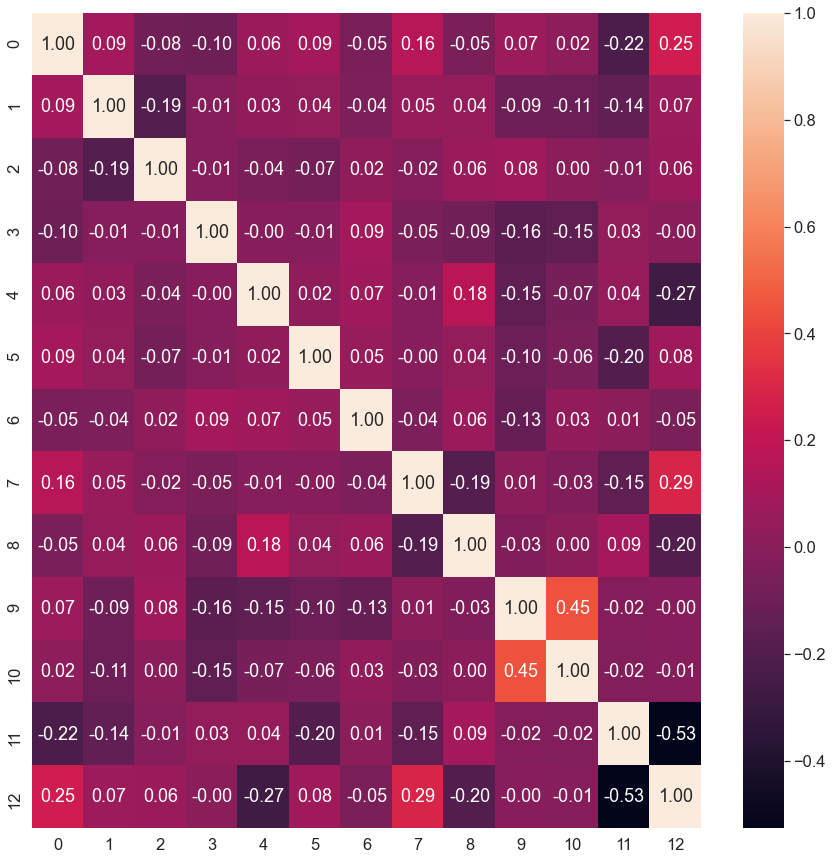

In [16]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15,15))
sns.heatmap(pd.DataFrame(data).corr(),annot=True, fmt='.2f')

# **Data Modeling**

In [17]:
f = 12 # for feature selection (12: all features), (3: 3 features), (5: 5 features)
x, y = feature_selection(f, data)

x = standardize(x)
#print(x)

print("data shape: ", x.shape)
print("label shape: ", y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)

data shape:  (299, 12)
label shape:  (299,)
train data:  (239, 12)
test data:  (60, 12)


---------- Logistic Regression ----------
Best parameter:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
Accuracy of Logistic Regression Classifier is:  90.00%
Recall of Logistic Regression Classifier is:  90.00%
Precision of Logistic Regression Classifier is:  90.68%
f1-score of Logistic Regression Classifier is:  90.22%


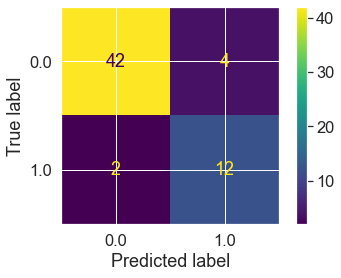

------------------ KNN ------------------
Best parameter:  {'n_neighbors': 9}
Best estimator:  KNeighborsClassifier(n_neighbors=9)
Accuracy of KNN Classifier is:  80.00%
Recall of KNN Classifier is:  80.00%
Precision of KNN Classifier is:  77.98%
f1-score of KNN Classifier is:  77.88%


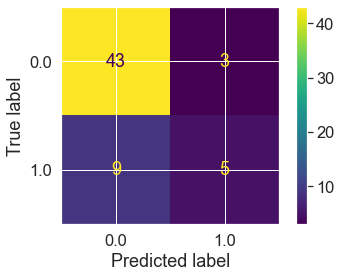

------------------ SVM ------------------
Best parameter:  {'C': 1, 'kernel': 'linear'}
Best estimator:  SVC(C=1, kernel='linear', probability=True)
Accuracy of SVM Classifier is:  88.33%
Recall of SVM Classifier is:  88.33%
Precision of SVM Classifier is:  88.09%
f1-score of SVM Classifier is:  88.18%


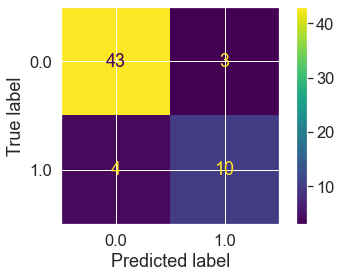

------------- Decision Tree -------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 6, 'random_state': 1}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)
Accuracy of Decision Tree Classifier is:  93.33%
Recall of Decision Tree Classifier is:  93.33%
Precision of Decision Tree Classifier is:  93.26%
f1-score of Decision Tree Classifier is:  93.15%


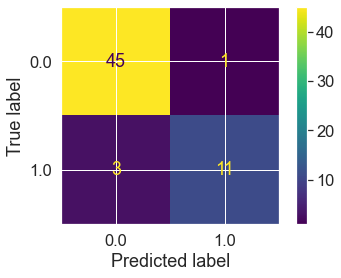

------------------ MLP ------------------
Best parameter:  {'activation': 'identity', 'hidden_layer_sizes': (8, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 20000, 'max_iter': 500, 'random_state': 0, 'solver': 'sgd', 'tol': 0.0001}
Best estimator:  MLPClassifier(activation='identity', hidden_layer_sizes=(8, 16), max_fun=20000,
              max_iter=500, random_state=0, solver='sgd')
Accuracy of MLP Classifier is:  88.33%
Recall of MLP Classifier is:  88.33%
Precision of MLP Classifier is:  88.09%
f1-score of MLP Classifier is:  88.18%


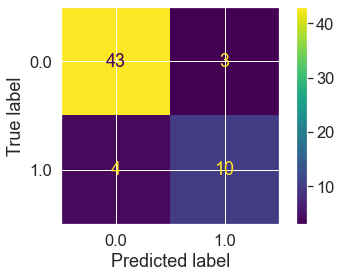

In [18]:
print('---------- Logistic Regression ----------')
LR_Classifier(x_train, x_test, y_train, y_test)

print('------------------ KNN ------------------')
KNN_Classifier(x_train, x_test, y_train, y_test)

print('------------------ SVM ------------------')
SVM_Classifier(x_train, x_test, y_train, y_test)

print('------------- Decision Tree -------------')
DT_Classifier(x_train, x_test, y_train, y_test)

print('------------------ MLP ------------------')
MLP_Classifier(x_train, x_test, y_train, y_test)

---------- Logistic Regression (Wrapper Method) ----------
Accuracy of Logistic Regression Classifier is:  90.00%
Recall of Logistic Regression Classifier is:  90.00%
Precision of Logistic Regression Classifier is:  90.68%
f1-score of Logistic Regression Classifier is:  90.22%


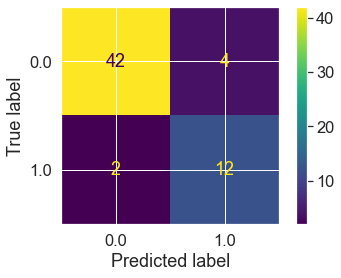

Number of selected feature: 8
Accuracy of Logistic Regression Classifier is:  90.00%
------------------ KNN (Wrapper Method) ------------------
------------------ SVM (Wrapper Method) ------------------
Number of selected feature: 12
Accuracy of SVM Classifier is:  88.33%
Recall of SVM Classifier is:  88.33%
Precision of SVM Classifier is:  88.09%
f1-score of SVM Classifier is:  88.18%


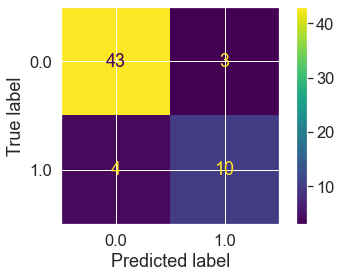

------------- Decision Tree (Wrapper Method) -------------
Number of selected feature: 10
Accuracy of Decision Tree Classifier is:  93.33%
Recall of Decision Tree Classifier is:  93.33%
Precision of Decision Tree Classifier is:  93.26%
f1-score of Decision Tree Classifier is:  93.15%


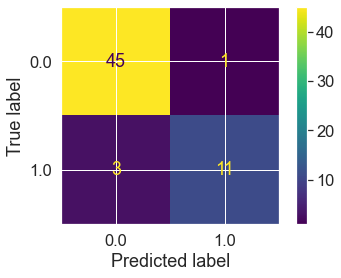

------------------ MLP (Wrapper Method) ------------------
Number of selected feature: 2
Accuracy of MLP Classifier is:  81.67%
Recall of MLP Classifier is:  81.67%
Precision of MLP Classifier is:  82.15%
f1-score of MLP Classifier is:  81.88%


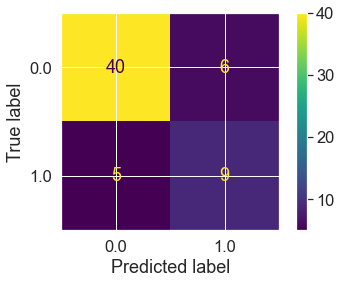

In [19]:
print('---------- Logistic Regression (Wrapper Method) ----------')
LR_Classifier_WrapperMethod(x_train, x_test, y_train, y_test)

print('------------------ KNN (Wrapper Method) ------------------')
# KNN_Classifier_WrapperMethod(x_train, x_test, y_train, y_test)

print('------------------ SVM (Wrapper Method) ------------------')
SVM_Classifier_WrapperMethod(x_train, x_test, y_train, y_test)

print('------------- Decision Tree (Wrapper Method) -------------')
DT_Classifier_WrapperMethod(x_train, x_test, y_train, y_test)

print('------------------ MLP (Wrapper Method) ------------------')
MLP_Classifier_WrapperMethod(x_train, x_test, y_train, y_test)

In [21]:
f = 3 # for feature selection (12: all features), (3: 3 features), (5: 5 features)
x, y = feature_selection(f, data)

x = standardize(x)
#print(x)

print("data shape: ", x.shape)
print("label shape: ", y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)

data shape:  (299, 3)
label shape:  (299,)
train data:  (239, 3)
test data:  (60, 3)


---------- Logistic Regression ----------
Best parameter:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
Accuracy of Logistic Regression Classifier is:  88.33%
Recall of Logistic Regression Classifier is:  88.33%
Precision of Logistic Regression Classifier is:  88.67%
f1-score of Logistic Regression Classifier is:  88.47%


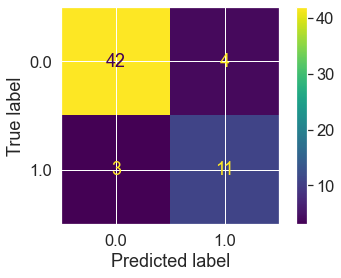

------------------ KNN ------------------
Best parameter:  {'n_neighbors': 3}
Best estimator:  KNeighborsClassifier(n_neighbors=3)
Accuracy of KNN Classifier is:  86.67%
Recall of KNN Classifier is:  86.67%
Precision of KNN Classifier is:  86.67%
f1-score of KNN Classifier is:  86.67%


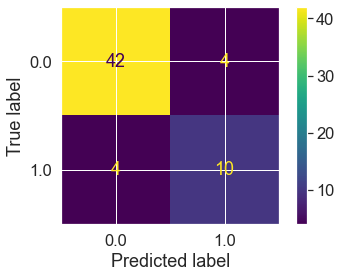

------------------ SVM ------------------
Best parameter:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, gamma=0.1, probability=True)
Accuracy of SVM Classifier is:  86.67%
Recall of SVM Classifier is:  86.67%
Precision of SVM Classifier is:  86.67%
f1-score of SVM Classifier is:  86.67%


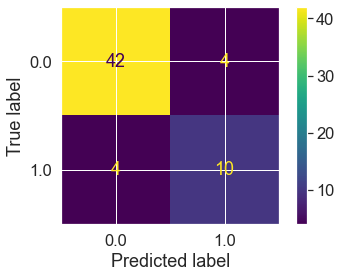

------------- Decision Tree -------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 1}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)
Accuracy of Decision Tree Classifier is:  88.33%
Recall of Decision Tree Classifier is:  88.33%
Precision of Decision Tree Classifier is:  87.93%
f1-score of Decision Tree Classifier is:  87.82%


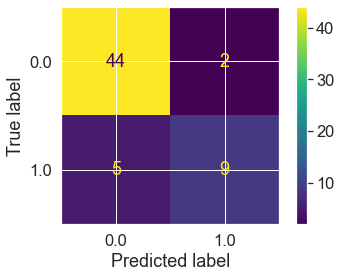

------------------ MLP ------------------
Best parameter:  {'activation': 'relu', 'hidden_layer_sizes': (8, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 20000, 'max_iter': 500, 'random_state': 0, 'solver': 'adam', 'tol': 0.0001}
Best estimator:  MLPClassifier(hidden_layer_sizes=(8, 16), max_fun=20000, max_iter=500,
              random_state=0)
Accuracy of MLP Classifier is:  86.67%
Recall of MLP Classifier is:  86.67%
Precision of MLP Classifier is:  86.67%
f1-score of MLP Classifier is:  86.67%


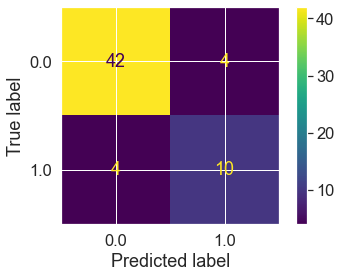

In [22]:
print('---------- Logistic Regression ----------')
LR_Classifier(x_train, x_test, y_train, y_test)

print('------------------ KNN ------------------')
KNN_Classifier(x_train, x_test, y_train, y_test)

print('------------------ SVM ------------------')
SVM_Classifier(x_train, x_test, y_train, y_test)

print('------------- Decision Tree -------------')
DT_Classifier(x_train, x_test, y_train, y_test)

print('------------------ MLP ------------------')
MLP_Classifier(x_train, x_test, y_train, y_test)

In [23]:
f = 3 # for feature selection (12: all features), (3: 3 features), (5: 5 features)
x, y = feature_selection(f, data)

x = standardize(x)

print("data shape: ", x.shape)
print("label shape: ", y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)

data shape:  (299, 3)
label shape:  (299,)
train data:  (239, 3)
test data:  (60, 3)


---------- Logistic Regression ----------
Best parameter:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
Accuracy of Logistic Regression Classifier is:  88.33%
Recall of Logistic Regression Classifier is:  88.33%
Precision of Logistic Regression Classifier is:  88.67%
f1-score of Logistic Regression Classifier is:  88.47%


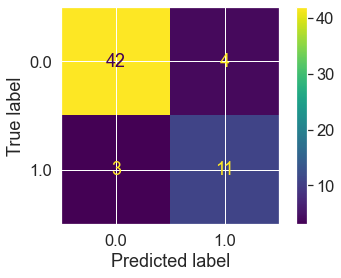

------------------ KNN ------------------
Best parameter:  {'n_neighbors': 3}
Best estimator:  KNeighborsClassifier(n_neighbors=3)
Accuracy of KNN Classifier is:  86.67%
Recall of KNN Classifier is:  86.67%
Precision of KNN Classifier is:  86.67%
f1-score of KNN Classifier is:  86.67%


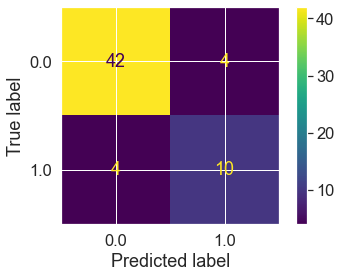

------------------ SVM ------------------
Best parameter:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, gamma=0.1, probability=True)
Accuracy of SVM Classifier is:  86.67%
Recall of SVM Classifier is:  86.67%
Precision of SVM Classifier is:  86.67%
f1-score of SVM Classifier is:  86.67%


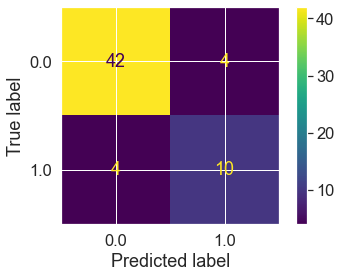

------------- Decision Tree -------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 1}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)
Accuracy of Decision Tree Classifier is:  88.33%
Recall of Decision Tree Classifier is:  88.33%
Precision of Decision Tree Classifier is:  87.93%
f1-score of Decision Tree Classifier is:  87.82%


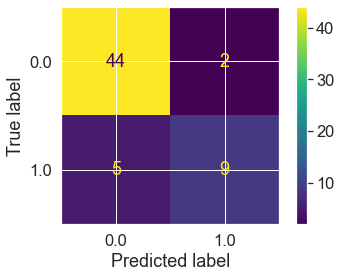

------------------ MLP ------------------
Best parameter:  {'activation': 'relu', 'hidden_layer_sizes': (8, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 20000, 'max_iter': 500, 'random_state': 0, 'solver': 'adam', 'tol': 0.0001}
Best estimator:  MLPClassifier(hidden_layer_sizes=(8, 16), max_fun=20000, max_iter=500,
              random_state=0)
Accuracy of MLP Classifier is:  86.67%
Recall of MLP Classifier is:  86.67%
Precision of MLP Classifier is:  86.67%
f1-score of MLP Classifier is:  86.67%


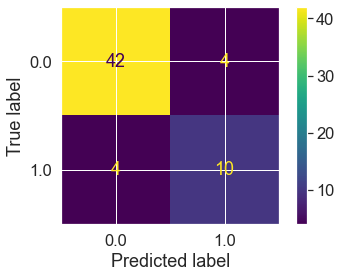

In [24]:
print('---------- Logistic Regression ----------')
LR_Classifier(x_train, x_test, y_train, y_test)

print('------------------ KNN ------------------')
KNN_Classifier(x_train, x_test, y_train, y_test)

print('------------------ SVM ------------------')
SVM_Classifier(x_train, x_test, y_train, y_test)

print('------------- Decision Tree -------------')
DT_Classifier(x_train, x_test, y_train, y_test)

print('------------------ MLP ------------------')
MLP_Classifier(x_train, x_test, y_train, y_test)

## PCA

[0.13858049 0.13159129 0.10567855 0.09299485 0.0858236  0.08240632
 0.07361317 0.07044072 0.06366814 0.05898425 0.05366763 0.04255099]


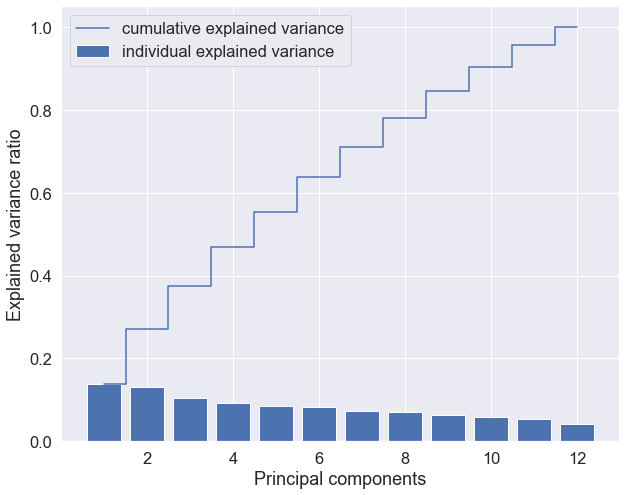

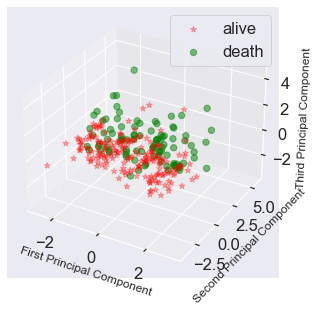

[0.13858049 0.13159129 0.10567855 0.09299485 0.0858236  0.08240632
 0.07361317 0.07044072 0.06366814 0.05898425 0.05366763 0.04255099]


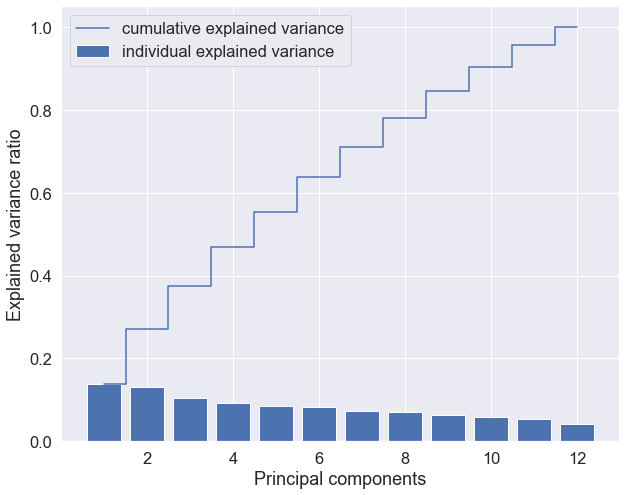

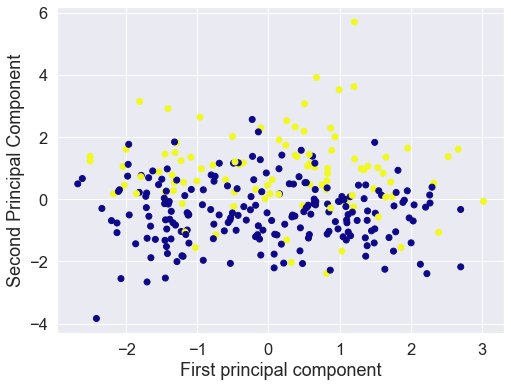

In [25]:
f = 12 # for feature selection (12: all features), (3: 3 features), (5: 5 features)
x, y = feature_selection(f, data)
x = standardize(x)

COMPONENTS = 3 # 2 or 3   
x_pca = pca_function(x, y, COMPONENTS)
#print(x_pca3.shape)

COMPONENTS = 2 # 2 or 3   
x_pca = pca_function(x, y, COMPONENTS)
#print(x_pca2.shape)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_pca[:,0:9], y, random_state=1, test_size=0.2)
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)

train data:  (239, 9)
test data:  (60, 9)


---------- Logistic Regression ----------
Best parameter:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
Accuracy of Logistic Regression Classifier is:  93.33%
Recall of Logistic Regression Classifier is:  93.33%
Precision of Logistic Regression Classifier is:  93.33%
f1-score of Logistic Regression Classifier is:  93.33%


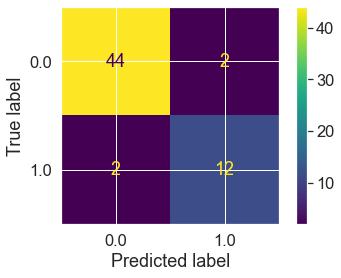

------------------ KNN ------------------
Best parameter:  {'n_neighbors': 9}
Best estimator:  KNeighborsClassifier(n_neighbors=9)
Accuracy of KNN Classifier is:  80.00%
Recall of KNN Classifier is:  80.00%
Precision of KNN Classifier is:  78.02%
f1-score of KNN Classifier is:  76.80%


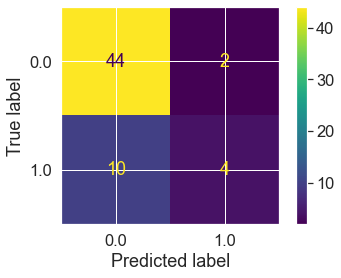

------------------ SVM ------------------
Best parameter:  {'C': 100, 'kernel': 'linear'}
Best estimator:  SVC(C=100, kernel='linear', probability=True)
Accuracy of SVM Classifier is:  85.00%
Recall of SVM Classifier is:  85.00%
Precision of SVM Classifier is:  84.25%
f1-score of SVM Classifier is:  84.34%


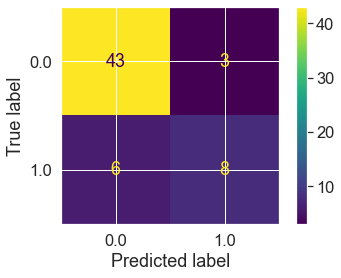

------------- Decision Tree -------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 1}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)
Accuracy of Decision Tree Classifier is:  78.33%
Recall of Decision Tree Classifier is:  78.33%
Precision of Decision Tree Classifier is:  77.81%
f1-score of Decision Tree Classifier is:  78.05%


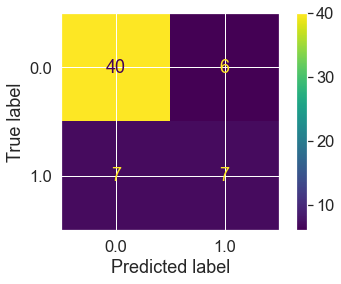

------------------ MLP ------------------
Best parameter:  {'activation': 'identity', 'hidden_layer_sizes': (8, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 20000, 'max_iter': 500, 'random_state': 0, 'solver': 'sgd', 'tol': 0.0001}
Best estimator:  MLPClassifier(activation='identity', hidden_layer_sizes=(8, 16), max_fun=20000,
              max_iter=500, random_state=0, solver='sgd')
Accuracy of MLP Classifier is:  86.67%
Recall of MLP Classifier is:  86.67%
Precision of MLP Classifier is:  86.13%
f1-score of MLP Classifier is:  85.83%


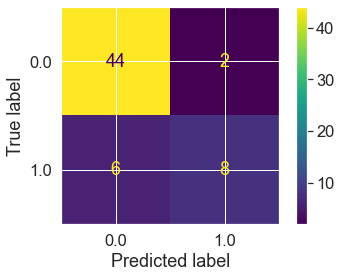

In [27]:
print('---------- Logistic Regression ----------')
LR_Classifier(x_train, x_test, y_train, y_test)

print('------------------ KNN ------------------')
KNN_Classifier(x_train, x_test, y_train, y_test)

print('------------------ SVM ------------------')
SVM_Classifier(x_train, x_test, y_train, y_test)

print('------------- Decision Tree -------------')
DT_Classifier(x_train, x_test, y_train, y_test)

print('------------------ MLP ------------------')
MLP_Classifier(x_train, x_test, y_train, y_test)

x_train, x_test, y_train, y_test = train_test_split(x_pca2, y, random_state=1, test_size=0.2)
print('train data: ', x_train.shape)
print('test data: ', x_test.shape)

print('---------- Logistic Regression ----------')
LR_Classifier(x_train, x_test, y_train, y_test)

print('------------------ KNN ------------------')
KNN_Classifier(x_train, x_test, y_train, y_test)

print('------------------ SVM ------------------')
SVM_Classifier(x_train, x_test, y_train, y_test)

print('------------- Decision Tree -------------')
DT_Classifier(x_train, x_test, y_train, y_test)

print('------------------ MLP ------------------')
MLP_Classifier(x_train, x_test, y_train, y_test)

## Ensemble

In [ ]:
#Defining Hybrid Ensemble Learning Model
# create the sub-models
estimators = []

#Defining 5 Logistic Regression Models
model11 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic1', model11))
model12 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic2', model12))
model13 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic3', model13))
model14 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic4', model14))
model15 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic5', model15))

#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier(max_depth = 3)
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier(max_depth = 4)
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier(max_depth = 5)
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier(max_depth = 2)
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier(max_depth = 3)
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC(kernel = 'linear')
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))
model24 = SVC(kernel = 'rbf')
estimators.append(('svm4', model24))
model25 = SVC(kernel = 'linear')
estimators.append(('svm5', model25))

#Defining 5 K-NN classifiers
model26 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
estimators.append(('knn1', model26))
model27 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
estimators.append(('knn2', model27))
model28 = KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2)
estimators.append(('knn3', model28))
model29 = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p = 1)
estimators.append(('knn4', model29))
model30 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 1)
estimators.append(('knn5', model30))

# #Defining 5 MLP classifiers
model31 = MLPClassifier()
estimators.append(('mlp1', model31))
model32 = MLPClassifier()
estimators.append(('mlp2', model32))
model33 = MLPClassifier()
estimators.append(('mlp3', model33))
model34 = MLPClassifier()
estimators.append(('mlp4', model34))
model35 = MLPClassifier()
estimators.append(('mlp5', model35))